In [62]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

from tensorflow.keras.layers import Dense
from tensorflow.keras import Model
from tensorflow.keras import layers
from tensorflow import keras
import os
import sys
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import csv
import pickle
from scipy.stats import linregress
from sklearn.model_selection import train_test_split
from datetime import datetime
import numpy as np
from sklearn.preprocessing import Normalizer
# from get_dataset import datasets
from sklearn.svm import SVR
from sklearn.ensemble import BaggingRegressor
from sklearn.datasets import make_regression

sys.path.append("..")
sys.path.append("../analyze")
sys.path.append("../measuring_volume")
sys.path.append("../common")
import pickle
from classify_seq import make_input_seq as mis

import keras_tuner as kt

type_of_l = "L3"

TensorFlow version: 2.16.1


In [63]:
np.__version__

'1.26.4'

In [64]:
pwd

'/Users/hyakuzukamaya/Desktop/lab/SA-EDS/scripts'

## Loading a dataset

## Split into train data and test data as dataset
- データセットとして使用するデータを取得する。
- trainデータとtestデータに分割する。（例えば80%をtrainデータに、20%をtestデータに、など。）
- 書き方はデータセットとして使用するデータの type による。もし、numpy の形で持っているならhttps://www.tensorflow.org/tutorials/load_data/numpy?hl=ja が参考になります。

データセットからx, yを作成する

In [65]:
# [0, 1, ... 0] + temperature
f1 = open("../dataset/x_int_initial_L3.pkl", "rb")
f2 = open("../dataset/L3_data_int_initial.pkl", "rb")
domain_seq_dic = pickle.load(f1)
value_dic = pickle.load(f2)
domain_lst = mis.seq_lst(f"../conf/input_seq_{type_of_l}.csv")

f1.close()
f2.close()

x_data = []
y_data = []

for key in domain_seq_dic:
    print(key)
    new_x = []
    for domain in domain_lst:
        new_x.append(domain_seq_dic[key]["domain"][domain])
    new_x.append(int(key[0]))
    new_x.append(float(domain_seq_dic[key]['eigenValue_2']))
    x_data.append(new_x)
    y_data.append(value_dic[(key[0], key[1][1:])]['sigmoid']["b"]/value_dic[(key[0], key[1][1:])]['sigmoid']["c"])

print(x_data)
print(y_data)



('277', '/home/user/SA-EDS/int_initial/L3_initial_0')
('298', '/home/user/SA-EDS/int_initial/L3_initial_0')
('308', '/home/user/SA-EDS/int_initial/L3_initial_0')
('318', '/home/user/SA-EDS/int_initial/L3_initial_0')
('328', '/home/user/SA-EDS/int_initial/L3_initial_0')
('338', '/home/user/SA-EDS/int_initial/L3_initial_0')
('348', '/home/user/SA-EDS/int_initial/L3_initial_0')
('358', '/home/user/SA-EDS/int_initial/L3_initial_0')
('277', '/home/user/SA-EDS/int_initial/L3_initial_1')
('298', '/home/user/SA-EDS/int_initial/L3_initial_1')
('308', '/home/user/SA-EDS/int_initial/L3_initial_1')
('318', '/home/user/SA-EDS/int_initial/L3_initial_1')
('328', '/home/user/SA-EDS/int_initial/L3_initial_1')
('338', '/home/user/SA-EDS/int_initial/L3_initial_1')
('348', '/home/user/SA-EDS/int_initial/L3_initial_1')
('358', '/home/user/SA-EDS/int_initial/L3_initial_1')
('277', '/home/user/SA-EDS/int_initial/L3_initial_2')
('298', '/home/user/SA-EDS/int_initial/L3_initial_2')
('308', '/home/user/SA-EDS/i

In [66]:
x_data = np.array(x_data)
y_data = np.array(y_data)

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2)
print(len(x_train))
print(len(x_test))
print(len(y_train))
print(len(y_train))

128
32
128
128


## Set my model
- input_shape は入力データのサイズ。
- モデルの定義方法は調べればたくさん出てきますが、例えばここ： https://sinyblog.com/deaplearning/keras_how_to/ 
- 最後の層の出力は、期待する出力データのサイズ
- [model](https://github.com/si-tm/docs-L30n/blob/master/site/ja/tutorials/quickstart/beginner.py)

In [67]:
def build_model():
    
    # model = tf.keras.models.Sequential([
    # tf.keras.layers.Flatten(input_shape=(x_train.shape[1],)),
    # tf.keras.layers.Dense(128, activation='relu'), # units=128 : 出力空間の次元数
    # tf.keras.layers.Dropout(0.2), # 入力にドロップアウトを適用する rate=0.2 : 入力ユニットをドロップする割合
    # tf.keras.layers.Dense(1) 
    # ])

    model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(x_train.shape[1],)),
    tf.keras.layers.Dense(128, activation='relu', name="layer1"), # units=128 : 出力空間の次元数
    tf.keras.layers.Dense(128, activation='relu', name="layer2"), # units=128 : 出力空間の次元数 # units=128 : 出力空間の次元数
    # tf.keras.layers.Dense(128, activation='relu', name="layer3"), # units=128 : 出力空間の次元数
    # tf.keras.layers.Dense(128, activation='relu', name="layer4"), # units=128 : 出力空間の次元数 # units=128 : 出力空間の次元数
    # tf.keras.layers.Dense(128, activation='relu', name="layer5"), # units=128 : 出力空間の次元数 # units=128 : 出力空間の次元数
    tf.keras.layers.Dropout(0.2), # 入力にドロップアウトを適用する rate=0.2 : 入力ユニットをドロップする割合
    tf.keras.layers.Dense(1) 
    ])

    optimizer = tf.keras.optimizers.Adam() # optimizers も Adam 以外に色々種類があります。調べてみてください！

    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse']) # loss 関数に何を採用するかはどんな問題を解きたいのかによります。
                                        #ここでは MSE を採用していますが、他にも色々な選択肢があります。調べてみてください！
    return model

In [68]:
model = build_model()

/Users/hyakuzukamaya/Library/Python/3.9/lib/python/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [69]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 1730)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer1 (Dense)                  │ (None, 128)            │       221,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer2 (Dense)                  │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 238,209 (930.50 KB)

 Trainable params: 238,209 (930.50 KB)

 Non-trainable params: 0 (0.00 B)

In [70]:
example_batch = x_train[:10]
print(example_batch.shape)
example_result = model.predict(example_batch)
# example_result

(10, 1730)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


In [71]:
print(example_result)

[[2.5053377]
 [2.2894096]
 [2.569068 ]
 [2.5285797]
 [2.6053715]
 [2.4577427]
 [2.2485342]
 [2.4250183]
 [1.9813428]
 [2.0648546]]


In [72]:
# エポックが終わるごとにドットを一つ出力することで進捗を表示
class PrintDot(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

# early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
EPOCHS = 100 # epoch 数も考慮しよう
# EPOCHS = 100 # epoch 数も考慮しよう

history = model.fit(
    x_train, y_train,
    epochs=EPOCHS, validation_split = 0.2, verbose=0,
    callbacks=[PrintDot()]
)


....................................................................................................

In [73]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
95,35.419109,2.165203,35.419109,2.962793,1.390632,2.962793,95
96,35.537312,2.164858,35.537312,3.242083,1.432073,3.242083,96
97,35.877159,2.114138,35.877159,3.035335,1.402834,3.035335,97
98,35.454494,2.215168,35.454494,2.845891,1.425937,2.845891,98
99,35.951595,2.342991,35.951595,3.159569,1.524312,3.159569,99


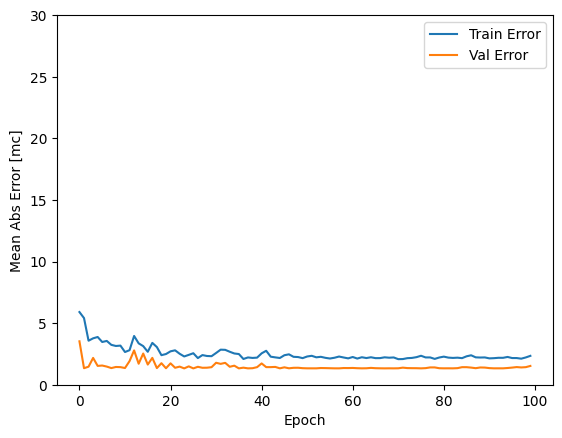

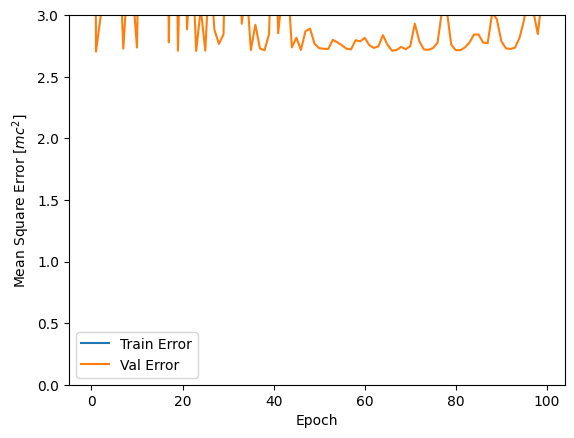

In [74]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [mc]')
    plt.plot(hist['epoch'], hist['mae'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'], label = 'Val Error')
    plt.ylim([0,30])
    plt.legend()

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$mc^2$]')
    plt.plot(hist['epoch'], hist['mse'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'], label = 'Val Error')
    plt.ylim([0,3])
    plt.legend()
    plt.show()


plot_history(history)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


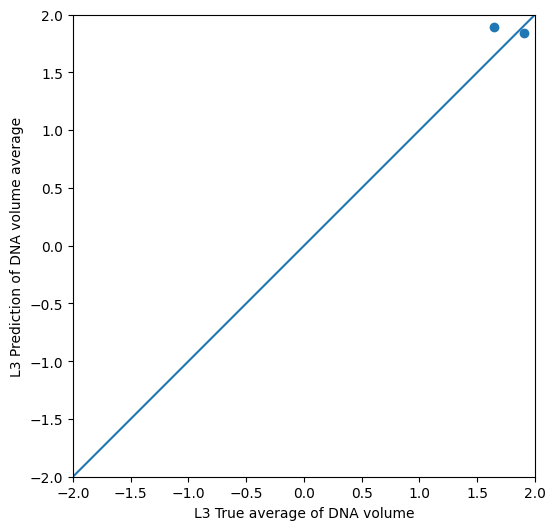

In [75]:
test_predictions = model.predict(x_test).flatten()
res = linregress(y_test, test_predictions)

plt.figure(figsize=(6,6))
plt.scatter(y_test, test_predictions)
# plt.xlabel('True Values [mc]')
# plt.ylabel('Predictions [mc]')
plt.xlabel('L3 True average of DNA volume')
plt.ylabel('L3 Prediction of DNA volume average')
plt.axis('equal')
plt.axis('square')
plt.xlim([-2,2])
plt.ylim([-2,2])
_ = plt.plot([-2,2], [-2,2])

plt.plot([-2,2], res.intercept + res.slope*np.array([-2, 2]), 'r', label='fitted line')

# normalizer 学習前

In [76]:
# トレーニングした model をどこかで使用したいなら以下のようにモデルを保存する
model.save('../saved_model/L3_int_initial_sigmoid.keras')

In [77]:
from sklearn.datasets import load_diabetes, make_regression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor, GradientBoostingRegressor, StackingRegressor, VotingRegressor
from sklearn.linear_model import RidgeCV, LinearRegression
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
from tensorflow import keras 
import tensorflow as tf
import pandas as pd

In [78]:
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor
def randomforest_regressor(x, y, x_train, x_test, y_train, y_test):
    regr = RandomForestRegressor(max_depth=2, random_state=0)
    regr.fit(x_train, y_train)
    return regr.score(x_test, y_test)


# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesRegressor.html#sklearn.ensemble.ExtraTreesRegressor
def extratrees_regressor(x, y, x_train, x_test, y_train, y_test):
    # X_train, X_test, y_train, y_test = train_test_split(
    #     X, y, random_state=0)
    reg = ExtraTreesRegressor(n_estimators=100, random_state=0).fit(
    x_train, y_train)
    return reg.score(x_test, y_test)

# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html#sklearn.ensemble.GradientBoostingRegressor
def gradientboosting_regressor(X_train, X_test, y_train, y_test):
    reg = GradientBoostingRegressor(random_state=0)
    reg.fit(X_train, y_train)
    return reg.score(X_test, y_test)

# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingRegressor.html#sklearn.ensemble.StackingRegressor
def stacking_regressor(X_train, X_test, y_train, y_test):
    X, y = load_diabetes(return_X_y=True)
    estimators = [
        ('lr', RidgeCV()),
        ('svr', LinearSVR(random_state=42))
    ]
    reg = StackingRegressor(
        estimators=estimators,
        final_estimator=RandomForestRegressor(n_estimators=10,
                                            random_state=42)
    )
    ref = reg.fit(X_train, y_train)
    return ref.score(X_test, y_test)

# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingRegressor.html#sklearn.ensemble.VotingRegressor
def voting_regressor(X, y, x_train, x_test, y_train, y_test):
    r1 = LinearRegression()
    r2 = RandomForestRegressor(n_estimators=10, random_state=1)
    r3 = KNeighborsRegressor()
    X = x_train
    y = y_train
    er = VotingRegressor([('lr', r1), ('rf', r2), ('r3', r3)])
    er = er.fit(X, y)
    er.predict(X)
    return er.score(x_test, y_test)

# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html#sklearn.ensemble.GradientBoostingRegressor
def histgradientboosting_regressor(X, y, x_train, x_test, y_train, y_test):
    # est = HistGradientBoostingRegressor().fit(X, y)
    est = HistGradientBoostingRegressor().fit(x_train, y_train)
    return est.score(x_test, y_test)

def get_model():
    # Create a simple model.
    inputs = keras.Input(shape=(32,))
    outputs = keras.layers.Dense(1)(inputs)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer="adam", loss="mean_squared_error")
    return model

def neural_mse(x_train, x_test, y_train, y_test, model_path='../../script/saved_model/random_L3_6_model'):
    #y_data = np.concatenate([np.array(y_train),np.array(y_test)])
    #print(type(y_data), y_data.shape)
    #min_val = y_data.min()
    #max_val = y_data.max()
    #y_train = (y_train - min_val)/(max_val - min_val)
    #y_test = (y_test - min_val)/(max_val - min_val)
    #x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2)

    model = keras.models.load_model(model_path)
    test_predictions = model.predict(x_test).flatten()
    for i in range(len(y_test)):
        print(f"Expected {y_test[i]} and got {test_predictions[i]}")

    #mse = tf.keras.losses.MeanSquaredError()
    u = ((y_test-test_predictions)**2).sum()
    v = ((y_test - y_test.mean()) ** 2).sum()

    return 1.0 - u/v #mse(y_test,test_predictions).numpy()

def new_neural_mse(x, y, x_train, x_test, y_train, y_test, model_path='../../script/saved_model/random_L3_6_model'):

    model = keras.models.load_model(model_path)
    test_predictions = model.predict(x_test).flatten()

    mse = tf.keras.losses.MeanSquaredError()

    return mse(y_test,test_predictions).numpy()


In [79]:
x = x_data
y = y_data

extratrees = extratrees_regressor(x, y, x_train, x_test, y_train, y_test)
randomforest = randomforest_regressor(x, y, x_train, x_test, y_train, y_test) 
gradientboosting = gradientboosting_regressor(x_train, x_test, y_train, y_test)
stacking = stacking_regressor(x_train, x_test, y_train, y_test)
voting = voting_regressor(x, y, x_train, x_test, y_train, y_test)
histgradientboosting = histgradientboosting_regressor(x, y, x_train, x_test, y_train, y_test)
neural_mse_score = neural_mse(x_train, x_test, y_train, y_test, model_path='../saved_model/L3_initial_eigen.keras')


/Users/hyakuzukamaya/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/hyakuzukamaya/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/hyakuzukamaya/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/hyakuzukamaya/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/hyakuzukamaya/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/hyakuzukamaya/Library/P

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Expected 2.0691208913792987 and got 57.91283416748047
Expected 0.037621783516510826 and got 70.12784576416016
Expected 2.2618306223451814 and got 61.591697692871094
Expected 2.7982422419933903 and got 62.81963348388672
Expected 2.0320530391844556 and got 62.42033386230469
Expected 0.0 and got 72.90177917480469
Expected -0.6796377050888707 and got 69.1325454711914
Expected 1.4525204120440383 and got 57.082672119140625
Expected 0.5999999947470636 and got 71.09722900390625
Expected 2.2745216672838953 and got 57.08552551269531
Expected 2.2739304649364906 and got 71.09406280517578
Expected 0.0 and got 71.39893341064453
Expected 1.9548798568969201 and got 64.66158294677734
Expected 2.278886687587808 and got 64.6541976928711
Expected 1.9110148476609279 and got 62.25907897949219
Expected 1.6264067262268462 and got 57.99992752075195
Expected 0.12265127310581705 and got 68.61592864990234
Expected 2.740887021033324 and got 64.56729888916016
Expected 2.1031522

In [80]:
lst = []
lst.append(["extratrees" ,extratrees])
lst.append(["randomforest", randomforest])
lst.append(["gradientboosting", gradientboosting])
lst.append(["stacking", stacking])
lst.append(["voting", voting])
lst.append(["histgradientboosting", histgradientboosting])
lst.append(["neural network", neural_mse_score])
    
df = pd.DataFrame(data=lst,columns=['regressor', 'score'])
print(df)



              regressor        score
0            extratrees   -17.441154
1          randomforest    -0.076605
2      gradientboosting   -35.109996
3              stacking    -2.526186
4                voting    -2.332375
5  histgradientboosting    -3.103773
6        neural network -1700.581700


In [81]:
def bagging_regressor(estimator, x_train, x_test, y_train, y_test):
    # BaggingRegressorのインスタンスを作成し、トレーニングデータにフィットさせる
    er = BaggingRegressor(estimator=estimator, n_estimators=10, random_state=1)
    er.fit(x_train, y_train)
    
    # モデルのスコアを計算して返す
    score = er.score(x_test, y_test)
    
    return score

In [82]:
x = x_data
y = y_data


# 各種モデルのバギングを実行
extratrees = bagging_regressor(ExtraTreesRegressor(n_estimators=10, random_state=1), x_train, x_test, y_train, y_test)
print("ExtraTreesRegressor with Bagging Score:", extratrees)

randomforest = bagging_regressor(RandomForestRegressor(n_estimators=10, random_state=1), x_train, x_test, y_train, y_test)
print("RandomForestRegressor with Bagging Score:", randomforest)

gradientboosting = bagging_regressor(GradientBoostingRegressor(n_estimators=10, random_state=1), x_train, x_test, y_train, y_test)
print("GradientBoostingRegressor with Bagging Score:", gradientboosting)

# スタッキングの例
estimators = [
    ('rf', RandomForestRegressor(n_estimators=10, random_state=1)),
    ('et', ExtraTreesRegressor(n_estimators=10, random_state=1))
]
stacking_estimator = StackingRegressor(estimators=estimators, final_estimator=LinearRegression())
stacking = bagging_regressor(stacking_estimator, x_train, x_test, y_train, y_test)
print("StackingRegressor with Bagging Score:", stacking)

histgradientboosting = bagging_regressor(HistGradientBoostingRegressor(random_state=1), x_train, x_test, y_train, y_test)
print("HistGradientBoostingRegressor with Bagging Score:", histgradientboosting)
neural_mse_score = neural_mse(x_train, x_test, y_train, y_test, model_path='../saved_model/L3_initial_eigen.keras')


ExtraTreesRegressor with Bagging Score: -5.106859675189857
RandomForestRegressor with Bagging Score: -2.371755190085298
GradientBoostingRegressor with Bagging Score: -1.53681266197832
StackingRegressor with Bagging Score: -0.005200653810970568
HistGradientBoostingRegressor with Bagging Score: -0.9557766604869424
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Expected 2.0691208913792987 and got 57.91283416748047
Expected 0.037621783516510826 and got 70.12784576416016
Expected 2.2618306223451814 and got 61.591697692871094
Expected 2.7982422419933903 and got 62.81963348388672
Expected 2.0320530391844556 and got 62.42033386230469
Expected 0.0 and got 72.90177917480469
Expected -0.6796377050888707 and got 69.1325454711914
Expected 1.4525204120440383 and got 57.082672119140625
Expected 0.5999999947470636 and got 71.09722900390625
Expected 2.2745216672838953 and got 57.08552551269531
Expected 2.2739304649364906 and got 71.09406280517578
Expected 0.0 and got 71.39893341064453
Expected 1.954879856896920

In [83]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.ensemble import BaggingRegressor, ExtraTreesRegressor, RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# サンプルデータ（例として生成します）
# X, y = make_regression(n_samples=100, n_features=20, noise=0.1, random_state=42)
# x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 各アルゴリズムの定義とバギングの適用
regressors = {
    "extratrees": ExtraTreesRegressor(),
    "randomforest": RandomForestRegressor(),
    "gradientboosting": GradientBoostingRegressor(),
    "histgradientboosting": HistGradientBoostingRegressor(),
    "neural network": MLPRegressor()
}

bagging_results = []
for name, reg in regressors.items():
    bagged_reg = BaggingRegressor(estimator=reg, n_estimators=10, random_state=42)
    bagged_reg.fit(x_train, y_train)
    y_pred = bagged_reg.predict(x_test)
    score = mean_squared_error(y_test, y_pred)
    bagging_results.append([name, score])

# データフレームの作成
df = pd.DataFrame(data=bagging_results, columns=['regressor', 'score'])
print(df)

# PDFへの保存
pdf_path = '../fig/regressor_scores_with_bagging.pdf'

# プロットをPDFに保存するための設定
with PdfPages(pdf_path) as pdf:
    # データフレームをプロット
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.axis('tight')
    ax.axis('off')
    table = ax.table(cellText=df.values, colLabels=df.columns, cellLoc='center', loc='center')

    # テーブルのスタイル設定
    table.auto_set_font_size(False)
    table.set_fontsize(7)
    table.scale(1.5, 1.5)

    # セルのスタイル設定
    for (i, j), cell in table.get_celld().items():
        cell.set_edgecolor('grey')
        if i == 0:  # Header row
            cell.set_text_props(weight='bold', color='white')
            cell.set_facecolor('#40466e')
        else:  # Data cells
            cell.set_facecolor('#f1f1f2')
        cell.set_height(0.05)
        cell.set_width(0.2)
    
    pdf.savefig(fig, bbox_inches='tight')
    plt.close()

print(f"DataFrame has been saved as {pdf_path}")


/Users/hyakuzukamaya/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/hyakuzukamaya/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/hyakuzukamaya/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/hyakuzukamaya/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
 

              regressor      score
0            extratrees  25.280844
1          randomforest  18.028832
2      gradientboosting  49.644835
3  histgradientboosting   8.359040
4        neural network   2.620652
DataFrame has been saved as ../fig/regressor_scores_with_bagging.pdf


/Users/hyakuzukamaya/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


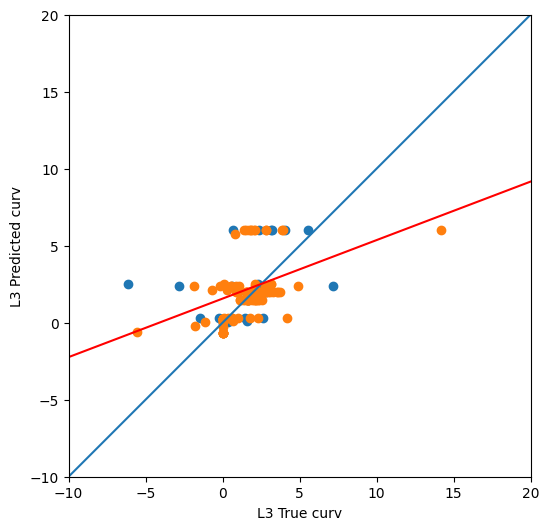

In [29]:
def randomforest_regressor(x_train, x_test, y_train, y_test):
    regr = RandomForestRegressor(max_depth=2,n_estimators=10)
    regr.fit(x_train, y_train)

    test_predictions = regr.predict(x_test).flatten()
    train_predictions = regr.predict(x_train).flatten()
    res = linregress(y_test, test_predictions)

    plt.figure(figsize=(6,6))
    plt.scatter(y_test, test_predictions)
    plt.scatter(y_train, train_predictions)
    # plt.xlabel('True Values [mc]')
    # plt.ylabel('Predictions [mc]')
    plt.xlabel('L3 True curv')
    plt.ylabel('L3 Predicted curv')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim([-10,20])
    plt.ylim([-10,20])
    _ = plt.plot([-10,20], [-10,20])

    plt.plot([-10,20], res.intercept + res.slope*np.array([-10, 20]), 'r', label='fitted line')

        # Save the model
    with open('../saved_model/randomforest_model_L3_sigmoid.pkl', 'wb') as f:
        pickle.dump(regr, f)
randomforest_regressor(x_train, x_test, y_train, y_test)

In [ ]:
def voting_regressor(x_train, x_test, y_train, y_test):
    r1 = LinearRegression()
    r2 = RandomForestRegressor(n_estimators=10)
    r3 = KNeighborsRegressor()
    X = x_train
    y = y_train
    er = VotingRegressor([('lr', r1), ('rf', r2), ('r3', r3)])
    er = er.fit(X, y)
    

    test_predictions = er.predict(x_test)
    train_predictions = er.predict(x_train)
    res = linregress(y_test, test_predictions)

    plt.figure(figsize=(6,6))
    plt.scatter(y_test, test_predictions)
    plt.scatter(y_train, train_predictions)
    # plt.xlabel('True Values [mc]')
    # plt.ylabel('Predictions [mc]')
    plt.xlabel('L3 True average of DNA volume')
    plt.ylabel('L3 Prediction of DNA volume average')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim([0,20])
    plt.ylim([0,20])
    _ = plt.plot([0,20], [0,20])

    plt.plot([0,20], res.intercept + res.slope*np.array([0, 20]), 'r', label='fitted line')

        # Save the model
    #with open('../saved_model/randomforest_model_L3.pkl', 'wb') as f:
    #    pickle.dump(regr, f)
voting_regressor(x_train, x_test, y_train, y_test)

In [36]:
from sklearn.metrics import r2_score


def bagging_regressor(x_train,x_test,y_train,y_test):
    X = x_train
    y = y_train
    # er = BaggingRegressor(estimator=RandomForestRegressor(n_estimators=10),n_estimators=10)
    er = BaggingRegressor(estimator=HistGradientBoostingRegressor(),n_estimators=10)
    er = er.fit(X, y)
    

    test_predictions = er.predict(x_test)
    train_predictions = er.predict(x_train)
    res = linregress(y_test, test_predictions)

    # Save the model
    with open('../saved_model/bagging_model_L3_int_initial_hist_sig.pkl', 'wb') as f:
        pickle.dump(er, f)


    plt.figure(figsize=(6,6))
    plt.scatter(y_train, train_predictions)
    plt.scatter(y_test, test_predictions)
    # plt.xlabel('True Values [mc]')
    # plt.ylabel('Predictions [mc]')
    plt.xlabel('L3 True average of DNA volume')
    plt.ylabel('L3 Prediction of DNA volume average')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim([-10,20])
    plt.ylim([-10,20])
    _ = plt.plot([-10,20], [-10,20])

    plt.plot([-10,20], res.intercept + res.slope*np.array([-10,20]), 'r', label='fitted line')

In [91]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
from scipy.stats import linregress
from sklearn.metrics import r2_score
import pickle

def bagging_regressor(x_train, x_test, y_train, y_test):
    X = x_train
    y = y_train
    # er = BaggingRegressor(estimator=RandomForestRegressor(n_estimators=10), n_estimators=10)
    er = BaggingRegressor(estimator=HistGradientBoostingRegressor(),n_estimators=10)

    er = er.fit(X, y)

    # Save the model
    with open('../saved_model/bagging_model_L3_initial.pkl', 'wb') as f:
        pickle.dump(er, f)

    test_predictions = er.predict(x_test)
    train_predictions = er.predict(x_train)
    res = linregress(y_test, test_predictions)

    max_lim = 20
    min_lim = -10

    plt.figure(figsize=(6, 6))
    plt.scatter(y_train, train_predictions, label='Train data')
    plt.scatter(y_test, test_predictions, label='Test data')
    plt.xlabel('True sigmoid value', fontsize=20)
    plt.ylabel('Predicted sigmoid value', fontsize=20)
    plt.axis('equal')
    plt.axis('square')
    plt.xlim([min_lim, max_lim])
    plt.ylim([min_lim, max_lim])
    plt.plot([min_lim, max_lim], [min_lim, max_lim], 'k--', label='Ideal line')

    r2 = r2_score(y_test, test_predictions)
    # Plot the fitted line
    fitted_line = res.intercept + res.slope * np.array([min_lim, max_lim])
    plt.plot([min_lim, max_lim], fitted_line, 'r', label='Fitted line')
    plt.legend()

    # Annotate the R² value on the plot
    plt.text(2, max_lim - 5, f'$R^2 = {r2:.2f}$', fontsize=20, color='red')

    # Display the plot
    plt.show()

    # Print the fitted line equation and R² score
    print(f"Fitted line: y = {res.intercept} + {res.slope}x")
    print(f"R² score for test data: {r2}")

# Example usage (assuming x_train, x_test, y_train, y_test are defined)
# bagging_regressor(x_train, x_test, y_train, y_test)


In [92]:
x_data = np.array(x_data)
y_data = np.array(y_data)

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2)
print(len(x_train))
print(len(x_test))
print(len(y_train))
print(len(y_train))

128
32
128
128


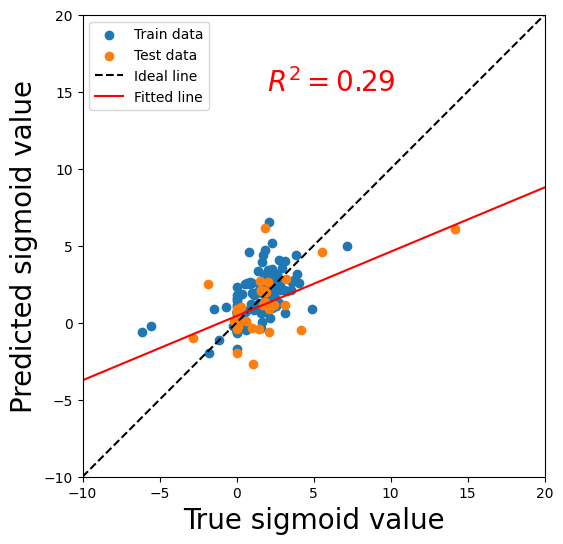

Fitted line: y = 0.43559479720710537 + 0.4173835082158672x
R² score for test data: 0.290127558182517


In [93]:
bagging_regressor(x_train, x_test, y_train, y_test)